## **Regression Model**: Characterizing the Role of CREs for Gene Expression
___

### 0. Importing dependencies

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.exceptions import ConvergenceWarning
import warnings

### 1. Importing and preparing dataframes for regression

   #### A. High variance ATAC-seq data

First, we will prepare our ATAC-seq data that was previously filtered for high variance. We will create three dataframes out of it:
- ***peaks_info***: contains the peak ID, the chromosome, and the position of the peak summit;

- ***peaks***: contains the accessibility data across all analyzed cell types; 

- ***peaks_transposed***: the transposed version of ***peaks*** (with the rows being the cell types).

In [21]:
peaks = pd.read_csv("ATAC_high_var.csv", index_col = False)
peaks.head()


,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,preT.DN1.Th,preT.DN2a.Th,...,T8.Tem.LCMV.d180.Sp,NKT.Sp,NKT.Sp.LPS.3hr,NKT.Sp.LPS.18hr,NKT.Sp.LPS.3d,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,variance
0,ImmGenATAC1219.peak_69,chr1,4468579,0.00,7.11,1.0,NaN,"Rp1,Sox17",14.81,22.31,...,5.94,0.98,2.75,2.85,1.49,0.41,2.57,3.52,7.89,21.404348
1,ImmGenATAC1219.peak_77,chr1,4490652,0.08,16.20,1.0,NaN,"Rp1,Sox17",59.36,43.17,...,4.29,1.16,1.54,1.19,2.18,9.93,8.79,16.02,47.78,297.171420
2,ImmGenATAC1219.peak_83,chr1,4496479,0.40,23.81,1.0,NaN,"Rp1,Sox17",40.73,28.06,...,41.12,25.50,18.36,16.14,19.20,36.48,28.99,26.03,33.68,182.666600
3,ImmGenATAC1219.peak_84,chr1,4496738,0.14,11.15,1.0,NaN,"Rp1,Sox17",23.05,8.10,...,23.94,12.37,9.06,10.64,9.17,16.15,16.66,17.12,17.28,42.240147
4,ImmGenATAC1219.peak_93,chr1,4547574,0.14,41.55,1.0,NaN,Sox17,20.15,7.29,...,1.07,7.23,3.46,1.20,5.36,0.41,0.71,2.69,5.80,16.024600


In [22]:
print(peaks.columns.tolist())

['ImmGenATAC1219.peakID', 'chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'variance']


In [23]:
meta_cols = [
    "chrom",
    "Summit",         
    "mm10.60way.phastCons_scores", 
    "_-log10_bestPvalue",          
    "Included.in.systematic.analysis",
    "TSS",                         
    "genes.within.100Kb",
    "variance"           
]

peaks_info = peaks[["ImmGenATAC1219.peakID", "chrom", "Summit"]]
peaks_info.rename(columns={"ImmGenATAC1219.peakID": "peak_ID"}, inplace=True)

peaks = peaks.drop(columns=meta_cols, errors="ignore")

C:\Users\boris\AppData\Local\Temp\ipykernel_21792\3725656176.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_info.rename(columns={"ImmGenATAC1219.peakID": "peak_ID"}, inplace=True)


In [24]:
print("Kept columns:", peaks.columns.tolist())

print("ATAC shape:", peaks.shape)
peaks.head()
peaks_info.head()

Kept columns: ['ImmGenATAC1219.peakID', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM']
ATAC shape: (75857, 30)


,peak_ID,chrom,Summit
0,ImmGenATAC1219.peak_69,chr1,4468579
1,ImmGenATAC1219.peak_77,chr1,4490652
2,ImmGenATAC1219.peak_83,chr1,4496479
3,ImmGenATAC1219.peak_84,chr1,4496738
4,ImmGenATAC1219.peak_93,chr1,4547574


In [25]:
peaks_transposed = peaks.T
peaks_transposed = peaks_transposed.iloc[1:].set_axis(peaks_transposed.iloc[0], axis=1)

peaks_transposed.head()

ImmGenATAC1219.peakID,ImmGenATAC1219.peak_69,ImmGenATAC1219.peak_77,ImmGenATAC1219.peak_83,ImmGenATAC1219.peak_84,ImmGenATAC1219.peak_93,ImmGenATAC1219.peak_95,ImmGenATAC1219.peak_96,ImmGenATAC1219.peak_109,ImmGenATAC1219.peak_119,ImmGenATAC1219.peak_125,...,ImmGenATAC1219.peak_512506,ImmGenATAC1219.peak_512507,ImmGenATAC1219.peak_512523,ImmGenATAC1219.peak_512533,ImmGenATAC1219.peak_512559,ImmGenATAC1219.peak_512569,ImmGenATAC1219.peak_512573,ImmGenATAC1219.peak_512577,ImmGenATAC1219.peak_512584,ImmGenATAC1219.peak_512586
preT.DN1.Th,14.81,59.36,40.73,23.05,20.15,10.18,36.51,12.79,17.42,5.81,...,26.59,19.05,24.77,34.1,3.47,16.26,9.35,7.02,15.76,12.97
preT.DN2a.Th,22.31,43.17,28.06,8.1,7.29,17.64,43.92,8.76,21.59,6.49,...,15.01,10.46,30.09,37.56,3.22,15.23,13.75,11.95,19.36,16.9
preT.DN2b.Th,5.17,50.58,12.6,8.83,2.67,15.71,14.61,4.77,20.48,4.83,...,16.36,11.95,47.1,33.86,4.83,23.51,25.28,17.03,18.31,17.03
preT.DN3.Th,2.0,28.94,30.46,13.55,3.08,14.12,11.1,3.08,11.15,4.0,...,22.34,24.17,38.09,37.96,5.9,17.92,15.38,19.55,18.56,9.2
T.DN4.Th,3.54,4.62,14.85,8.17,2.89,8.03,6.11,2.76,8.41,2.29,...,13.57,16.93,34.49,34.34,9.35,33.73,24.35,27.28,19.63,17.73


#### B. RNA-seq gene expression data and annotation

In [61]:
genes = pd.read_csv("RNA-seq/filtered_RNA_abT_Tact_Stem.csv")

genes = (
    genes
    .rename(columns={"Unnamed: 0": "gene_symbol"})
)

print(genes.shape)
genes.head()

(17535, 30)


,gene_symbol,preT.DN1.Th,preT.DN2a.Th,preT.DN2b.Th,preT.DN3.Th,T.DN4.Th,T.ISP.Th,T.DP.Th,T.4.Th,T.8.Th,...,T8.Tcm.LCMV.d180.Sp,T8.Tem.LCMV.d180.Sp,NKT.Sp,NKT.Sp.LPS.3hr,NKT.Sp.LPS.18hr,NKT.Sp.LPS.3d,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM
0,0610005C13Rik,1.022363,1.389747,1.024819,1.024482,1.026430,1.026217,3.010920,1.024462,1.024819,...,1.025833,1.024819,1.385805,1.025833,1.575395,1.024819,1.096732,1.096732,1.021750,1.021812
1,0610007P14Rik,162.641117,206.945221,209.187788,198.421365,215.056475,225.565360,73.904647,138.841383,139.863904,...,206.241084,205.309922,165.690720,133.234920,127.894194,195.147548,206.053987,246.105317,192.424636,204.298358
2,0610009B22Rik,68.070719,82.468806,89.769337,57.661619,76.399214,84.671456,32.828651,27.207241,36.169759,...,36.105700,34.348965,25.168975,33.305724,29.284365,33.322384,78.272059,78.837030,68.844751,76.418169
3,0610009L18Rik,15.450717,13.573968,14.427620,8.249482,1.683173,4.001953,5.595954,6.367369,6.505833,...,8.645607,7.268431,3.840215,1.025833,6.283540,12.791348,8.577159,16.791386,15.511549,16.947354
4,0610009O20Rik,160.246297,125.475307,155.928005,120.692893,118.433597,149.630866,92.040668,76.781112,87.529814,...,87.608325,56.128251,109.175415,91.992319,102.035627,108.414405,168.645852,157.926022,155.941641,186.261464


In [27]:
refFlat = pd.read_csv("refFlat", sep="\t", header=None)

refFlat.columns = [
    "gene", "transcript", "chrom", "strand", "txStart", "txEnd",
    "cdsStart", "cdsEnd", "exonCount", "exonStarts", "exonEnds"
]

refFlat.head()

,gene,transcript,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds
0,Wdsub1,NM_001159636,chr2,-,59855193,59882606,59855270,59878527,11,"59855193,59858609,59861560,59862619,59862816,5...","59855275,59858750,59861737,59862726,59862857,5..."
1,Rbm18,NM_001159635,chr2,-,36116078,36136704,36117814,36134247,6,"36116078,36120812,36122851,36127214,36134134,3...","36117974,36120898,36122938,36127251,36134263,3..."
2,Prrc2b,NM_001159634,chr2,+,32151147,32234537,32182511,32230742,32,"32151147,32182457,32183122,32185344,32187480,3...","32151291,32182626,32183300,32185447,32187553,3..."
3,Ildr2,NM_001164528,chr1,+,166254138,166316832,166254375,166310795,10,"166254138,166269304,166270498,166291415,166294...","166254466,166269637,166270618,166291472,166294..."
4,Perm1,NM_172417,chr4,+,156215926,156221307,156217000,156220222,4,"156215926,156216716,156219740,156220109,","156215975,156219185,156219866,156221307,"


In [28]:
gene_annotation_df = refFlat.drop_duplicates(subset=["gene"])

gene_annotation_df["tss"] = gene_annotation_df.apply(
    lambda row: row["txStart"] if row["strand"] == "+" else row["txEnd"],
    axis=1
)

gene_annotation_df = gene_annotation_df[["gene", "chrom", "strand", "tss"]]

C:\Users\boris\AppData\Local\Temp\ipykernel_21792\1540322388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_annotation_df["tss"] = gene_annotation_df.apply(


In [29]:
gene_annotation_df.head()

,gene,chrom,strand,tss
0,Wdsub1,chr2,-,59882606
1,Rbm18,chr2,-,36136704
2,Prrc2b,chr2,+,32151147
3,Ildr2,chr1,+,166254138
4,Perm1,chr4,+,156215926


In [30]:
gene_annotation_df.head()

,gene,chrom,strand,tss
0,Wdsub1,chr2,-,59882606
1,Rbm18,chr2,-,36136704
2,Prrc2b,chr2,+,32151147
3,Ildr2,chr1,+,166254138
4,Perm1,chr4,+,156215926


#### C. Mapping peaks to genes

In the next step we are mapping peaks to specific genes. For that purpose we are defining a window of 100 kb on each side of the TSS while also specifying which chromosomes contain those elements. Pote

In [ ]:
window = 100_000

merged = pd.merge(peaks_info, gene_annotation_df, on='chrom')

merged['distance'] = abs(merged['Summit'] - merged['tss'])

nearby = merged[merged['distance'] <= window]

In [ ]:
mapping_df = nearby[['gene', 'peak_ID']].drop_duplicates()

There are some small inconsistencies in the datasets. As it was mentioned in the notebook "regression_vs_correlation", around 700 genes from the RNA-seq data are missing in refFlat. For the purposes of our project, we will just ignore those, as they are only a small part of the over 17500 genes analyzed.

In [ ]:
rna_gene_list = genes['gene_symbol'].tolist()
print(rna_gene_list)

In [ ]:
print(genes.columns.tolist())

In [ ]:
mapping_df.head()

#### D. Regression

In [ ]:
genes_to_run = mapping_df['gene'].unique()[:1000]  # small test run

NameError: name 'mapping_df' is not defined

In [ ]:
# Optional: Ignore convergence warnings for LASSO
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Prepare output
results = []

# Loop over all genes that exist in both 'genes' and 'mapping_df'
#for gene in genes_to_run: 
for gene in mapping_df['gene'].unique():
    if gene not in genes.index:
        continue
    
    # Get nearby peaks for this gene
    peaks_for_gene = mapping_df[mapping_df['gene'] == gene]['peak_ID'].tolist()
    valid_peaks = [p for p in peaks_for_gene if p in peaks_transposed.columns]
    
    # Skip if no valid peaks
    if not valid_peaks:
        continue
    
    # Subset predictors and response
    X = peaks_transposed[valid_peaks]
    y = genes.loc[gene]

    # Make sure the dimensions match
    if X.shape[0] != y.shape[0]:
        continue

    # Fit LASSO with cross-validation
    model = LassoCV(cv=5, random_state=0).fit(X, y)

    # Save non-zero coefficients
    for peak, coef in zip(X.columns, model.coef_):
        if coef != 0:
            results.append({
                'gene': gene,
                'peak_ID': peak,
                'coefficient': coef,
                'r2': model.score(X, y)
            })

# Convert to DataFrame
lasso_results = pd.DataFrame(results)

In [31]:
lasso_results.to_csv("regression_results.csv")

In [32]:
lasso_results.head()

,Unnamed: 0,gene,peak_ID,coefficient,r2
0,0,Rp1,ImmGenATAC1219.peak_77,-0.012807,0.078561
1,1,Sox17,ImmGenATAC1219.peak_77,-0.003475,0.054538
2,2,Sox17,ImmGenATAC1219.peak_83,-0.001693,0.054538
3,3,Sox17,ImmGenATAC1219.peak_96,-0.003925,0.054538
4,4,Tcea1,ImmGenATAC1219.peak_137,0.922185,0.478855


___
### 2. Visualization of regression results

#### A. Distribution of coefficients

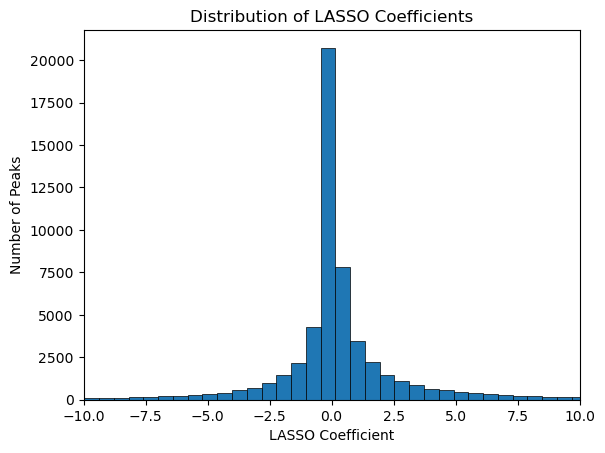

In [33]:
plt.hist(lasso_results["coefficient"], bins = 1000, edgecolor="black", linewidth=0.5)
plt.xlabel("LASSO Coefficient")
plt.xlim(-10, 10)
plt.ylabel("Number of Peaks")
plt.title("Distribution of LASSO Coefficients")
plt.show()

In [34]:
print(sum(lasso_results["coefficient"]==0))
print(lasso_results["coefficient"].min())
print(lasso_results["coefficient"].max())

0
-253.532701266754
341.9689586788897


#### B. Variance explained by the model

Text(0.5, 1.0, 'Variance in Expression Explained by CREs')

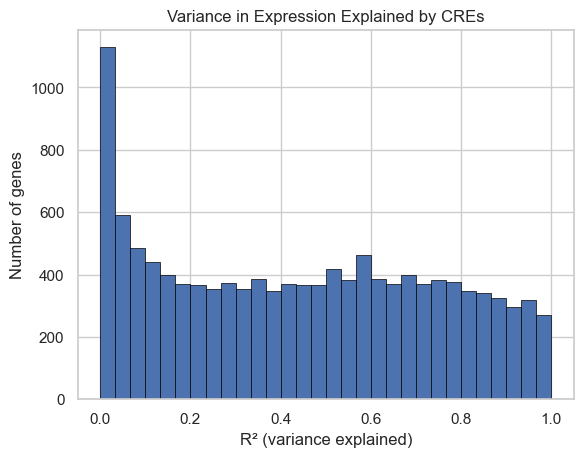

In [56]:
r2_per_gene = lasso_results.groupby("gene")["r2"].first()
r2_per_gene.hist(bins=30, edgecolor="black", linewidth=0.5)
plt.xlabel("R² (variance explained)")
plt.ylabel("Number of genes")
plt.title("Variance in Expression Explained by CREs")


In [37]:
lasso_results[lasso_results["gene"] == "Tcea1"]

,Unnamed: 0,gene,peak_ID,coefficient,r2
4,4,Tcea1,ImmGenATAC1219.peak_137,0.922185,0.478855
5,5,Tcea1,ImmGenATAC1219.peak_140,-1.782243,0.478855
6,6,Tcea1,ImmGenATAC1219.peak_146,-1.500372,0.478855
7,7,Tcea1,ImmGenATAC1219.peak_157,-1.232678,0.478855
8,8,Tcea1,ImmGenATAC1219.peak_158,2.424772,0.478855


The generated R<sup>2</sup> values can be visualized in a histogram like the one below. One can observe a relatively high amount of genes that are not so well explained by the model (R<sup>2</sup> around 0). Broadly speaking, the genes are split quite evenly with the median being between 0.4 and 0.5.

0.25    0.166104
0.50    0.443629
0.75    0.698506
0.90    0.865556
0.95    0.929999
Name: r2, dtype: float64


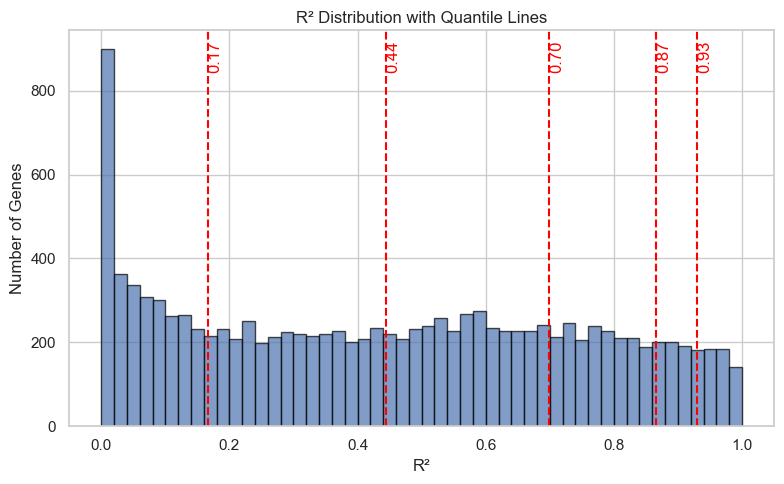

In [57]:
# Example: Quantiles of R² values per gene
r2_quantiles = r2_per_gene.quantile([0.25, 0.5, 0.75, 0.9, 0.95])
print(r2_quantiles)

plt.figure(figsize=(8, 5))
plt.hist(r2_per_gene, bins=50, edgecolor="black", alpha=0.7)
for q in r2_quantiles:
    plt.axvline(q, color="red", linestyle="--")
    plt.text(q, plt.ylim()[1]*0.9, f"{q:.2f}", color="red", rotation=90)
plt.title("R² Distribution with Quantile Lines")
plt.xlabel("R²")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

In [58]:
gene_r2

gene
0610005C13Rik    0.000000
0610009B22Rik    0.941427
0610009L18Rik    0.200254
0610010F05Rik    0.681569
0610010K14Rik    0.118889
                   ...   
Zyg11b           0.768940
Zyx              0.550184
Zzef1            0.172527
Zzz3             0.052441
a                0.662305
Name: r2, Length: 12139, dtype: float64

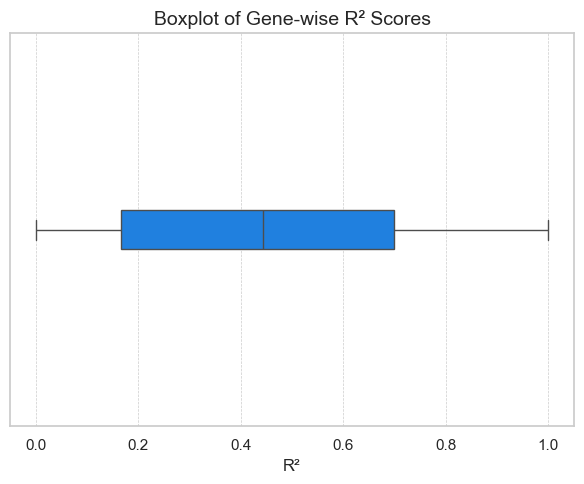

In [59]:
plt.figure(figsize=(6, 5))
sns.boxplot(x=r2_per_gene, color= "#0080FFFF", width=0.1)
plt.title("Boxplot of Gene-wise R² Scores", fontsize=14)
plt.xlabel("R²", fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


____
#### 3. Running regression on lineage specific genes

For the next part we will still need to use 'mapping_df', 'peaks_transposed', and 'genes' that we defined earlier in this notebook (look at 1A-C). The code for the regression is the same as the one above, however, for each lineage we will only use a part of the 'genes' dataframe containing the data for the corresponding cell types. We can also define a reusable function to reduce the amount of code needed.

#### A. Define lineage specific dataframes

In [ ]:
genes_progenitor = genes[["gene_symbol","LTHSC.34-.BM", "LTHSC.34+.BM", "STHSC.150-.BM", "MPP4.135+.BM"]]

genes_abT = genes[[
    "gene_symbol", "preT.DN1.Th", "preT.DN2a.Th", "preT.DN2b.Th", "preT.DN3.Th",
    "T.DN4.Th", "T.ISP.Th", "T.DP.Th", "T.4.Th", "T.8.Th",
    "T.4.Nve.Sp", "T.4.Nve.Fem.Sp", "T.8.Nve.Sp",
    "Treg.4.25hi.Sp", "Treg.4.FP3+.Nrplo.Co",
    "NKT.Sp"
    ]]

genes_Tact = genes[[
    "gene_symbol", "T.4.Sp.aCD3+CD40.18hr", "T8.TN.P14.Sp", "T8.TE.LCMV.d7.Sp",
    "T8.MP.LCMV.d7.Sp", "T8.IEL.LCMV.d7.Gut", "T8.Tcm.LCMV.d180.Sp", 
    "T8.Tem.LCMV.d180.Sp", "NKT.Sp.LPS.3hr","NKT.Sp.LPS.18hr", "NKT.Sp.LPS.3d"
    ]]

genes_progenitor.head()


,gene_symbol,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM
0,0610005C13Rik,1.096732,1.096732,1.021750,1.021812
1,0610007P14Rik,206.053987,246.105317,192.424636,204.298358
2,0610009B22Rik,78.272059,78.837030,68.844751,76.418169
3,0610009L18Rik,8.577159,16.791386,15.511549,16.947354
4,0610009O20Rik,168.645852,157.926022,155.941641,186.261464


#### B. Define a reusable function for the regression

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def run_lasso_for_gene(gene, expression_df, accessibility_df, mapping_df):
    """
    Runs LASSO regression for a single gene using nearby peaks.

    Parameters:
    - gene: str, the gene symbol
    - expression_df: DataFrame (genes x cell types)
    - accessibility_df: DataFrame (cell types x peaks)
    - mapping_df: DataFrame with columns ['gene', 'peak_ID']

    Returns:
    - DataFrame with non-zero coefficients and model R² (or empty DataFrame if skipped)
    """
    if gene not in expression_df.index:
        return pd.DataFrame()

    # Find nearby peaks
    peaks_for_gene = mapping_df[mapping_df['gene'] == gene]['peak_ID'].tolist()
    valid_peaks = [p for p in peaks_for_gene if p in accessibility_df.columns]

    if not valid_peaks:
        return pd.DataFrame()

    # Define predictors and response
    X = accessibility_df[valid_peaks]
    y = expression_df.loc[gene]

    if X.shape[0] != y.shape[0]:
        return pd.DataFrame()

    # Fit LASSO with cross-validation
    model = LassoCV(cv=5, random_state=0).fit(X, y)

    # Collect non-zero coefficients
    non_zero = model.coef_ != 0
    if not any(non_zero):
        return pd.DataFrame()

    return pd.DataFrame({
        'gene': gene,
        'peak_ID': X.columns[non_zero],
        'coefficient': model.coef_[non_zero],
        'r2': model.score(X, y)
    })

#### C. Regression

* **Progenitor cells**

In [ ]:
lasso_progenitor = run_lasso_for_gene(gene, genes_progenitor, peaks_transposed, mapping_df)

* **abT cells**

In [ ]:
lasso_abT = run_lasso_for_gene(gene, genes_abT, peaks_transposed, mapping_df)

* **T.act cells**

In [ ]:
lasso_Tact = run_lasso_for_gene(gene, genes_Tact, peaks_transposed, mapping_df)